# ingest raw data

In [1]:
from notebook_utils import *

# print modules and versions            
imports()

/home/ubuntu/py_36_env/lib/python3.6/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/ubuntu/py_36_env/lib/python3.6/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


pandas: 1.0.3
numpy: 1.18.2
scanpy.api: 1.4.4.post1
anndata: 0.6.22rc1
plotnine: 0.6.0
scipy: 1.4.1
more_itertools: 8.2.0
tqdm: 4.45.0


In [2]:
# settings
wkdir = '/home/ubuntu/data/DL20181011_melanocyte_test_data/local_data'

# read raw data (expression data) to pandas df
pre_adata = (pd.read_csv(f'{wkdir}/DL20190115_big_counts.txt', 
                      index_col=[0])
                .rename(columns = {'gene':'gene_name'})
                .set_index('gene_name'))
cell_names = ['_'.join(x.split('_')[:2]) for x in pre_adata.columns]
pre_adata.columns = cell_names

# read fetal supp data
pre_adata_supp1 = (pd.read_csv(f'{wkdir}/DL20190319_fetal_v2.csv')
                  .rename(columns = {'gene':'gene_name'})
                   .set_index('gene_name')
                  )

# read adult supp data
pre_adata_supp2 = (pd.read_csv(f'{wkdir}/DL20190417_adult_v2.csv')
                  .rename(columns = {'gene':'gene_name'})
                   .set_index('gene_name')
                  )

# merge with raw
pre_adata = pd.concat([pre_adata, pre_adata_supp1,pre_adata_supp2], axis=1)
cell_names = pre_adata.columns.tolist()

# metadata:
## download lastest from google drive and push to s3
meta_df = pd.read_csv(f'{wkdir}/DL20190417_mel_metadata.csv')
meta_df = meta_df.drop(['GWAS_consent', 
                        'sort_info_exported',
                       'sort_date',
                       'plate_order',
                       'sample_number',
                       'plate_status'], axis = 1)
possible_wells = [f'{y}{x}'for y in string.ascii_uppercase[:-10] for x in range(1,25)]
all_wells_df = pd.DataFrame()
for plate in meta_df.plate_barcode:
    well_df = pd.DataFrame({'well':possible_wells})
    well_df['plate_barcode'] = plate
    all_wells_df = pd.concat([all_wells_df, well_df], axis = 0)
    
meta_df = pd.merge(meta_df, all_wells_df, 'left', 'plate_barcode')
meta_df['cell_name'] = [f'{x}_{y}' for x,y in zip(meta_df.well, meta_df.plate_barcode)]

merged_anno = pd.merge(pd.DataFrame({'cell_name':cell_names}), meta_df, 'left', 'cell_name')
merged_anno = merged_anno.set_index('cell_name')



In [3]:
# rename columns for GEO matrix indexing

# outdf = pd.merge(pre_adata.T.reset_index(),
#                 merged_anno.loc[:,['patient_id']].reset_index().rename(columns={'cell_name':'index'}),
#                  'left',
#                  'index'
#                 )
# outdf['index'] = [f'{y}_{x}' for x,y in zip(outdf['index'],outdf['patient_id'])]
# outdf = (outdf
#          .drop('patient_id', axis = 1)
#          .set_index('index')
#          .T
#         )
# outdf.astype(int).to_csv('~/data/DL20181011_melanocyte_test_data/raw_matrix.csv')

# print anatomical locations of each sample for GEO metadata

# (merged_anno
#  .loc[:,['patient_id','anatomical_location']]
#  .drop_duplicates()
#  .sort_values('patient_id')
#  .groupby('patient_id')
#  .apply(lambda df: ','.join(df.anatomical_location))
#  .reset_index()
# )

## distribution of ngenes, nreads and cutoffs

/home/ubuntu/py_36_env/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ubuntu/py_36_env/lib/python3.6/site-packages/plotnine/layer.py:360: PlotnineWarning: stat_density : Removed 13 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


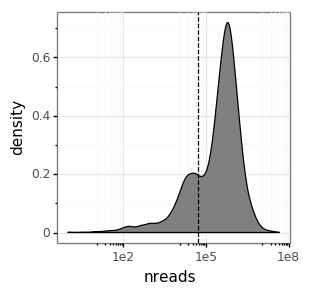

<ggplot: (8774791409093)>


/home/ubuntu/py_36_env/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ubuntu/py_36_env/lib/python3.6/site-packages/plotnine/layer.py:360: PlotnineWarning: stat_density : Removed 13 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


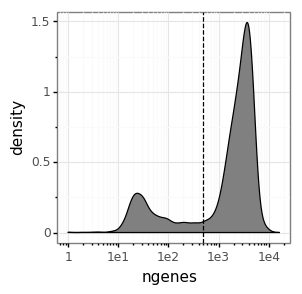

<ggplot: (-9223363262062260259)>


In [4]:
dist_df = pd.DataFrame({'nreads':pre_adata.astype(int).sum().values,
                        'ngenes':(pre_adata > 0).sum().values,
                        'cell_id':pre_adata.columns
                       }).set_index('cell_id')
plotnine.options.figure_size = (3,3)
plot = (ggplot(dist_df)
        + theme_bw()
        + geom_density(aes('nreads'), fill='grey')
        + geom_vline(aes(xintercept=50000), linetype='--')
        + scale_x_log10()
       )
print(plot)
plot = (ggplot(dist_df)
        + theme_bw()
        + geom_density(aes('ngenes'), fill='grey')
        + geom_vline(aes(xintercept=500), linetype='--')
        + scale_x_log10()
       )
print(plot)

/home/ubuntu/py_36_env/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ubuntu/py_36_env/lib/python3.6/site-packages/plotnine/layer.py:360: PlotnineWarning: stat_density : Removed 1124 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


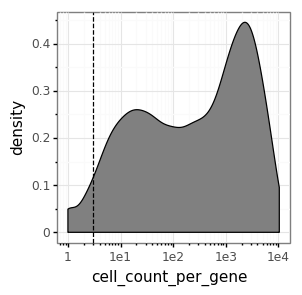

<ggplot: (8774792515848)>


In [5]:
passing_cells = (dist_df
                 .query('nreads >= 50000')
                 .query('ngenes >= 500')
                 .reset_index()['cell_id']
                 .tolist()
                )
filtered_pre_adata = pre_adata.loc[:, passing_cells]
dist_df2 = pd.DataFrame({'cell_count_per_gene':(filtered_pre_adata > 0).sum(axis=1)
                       })
plot = (ggplot(dist_df2)
        + theme_bw()
        + geom_density(aes('cell_count_per_gene'), fill='grey')
        + geom_vline(aes(xintercept=3), linetype='--')
        + scale_x_log10()
       )
print(plot)

# compile raw data

In [6]:
raw_adata = create_adata(pre_adata)
raw_adata.var['ribo'] = raw_adata.var_names.str.startswith(('RPL','RPS'))
raw_adata.var['ercc'] = np.array([True if 'ERCC' in x else False for x in raw_adata.var_names.tolist()])
anno_dict = {'age':'age',
             'age_bin':'age_bin',
             'plate_barcode':'plate',
             'general_location':'general_location',
             'anatomical_location':'anatomical_location',
             'race':'race',
             'sex':'sex',
             'sample_color':'color',
             'patient_id':'patient'}
append_anno(raw_adata, merged_anno, anno_dict)
technical_filters(raw_adata, min_genes=1250)
raw_adata = remove_ercc(raw_adata) 
raw_adata.raw = sc.pp.log1p(raw_adata, copy=True) # freeze raw state

Ingest raw data...
Append annotations...
Remove low-quality cells/genes...
Remove ERCC genes...


# append metadata to raw adata

## cycling cells
ref: https://www.biorxiv.org/content/biorxiv/early/2019/02/03/526848.full.pdf 
high = G2/M, low = G1/S

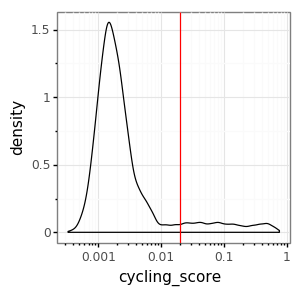

<ggplot: (8774791650361)>

In [7]:
cycling_module = ['TOP2A','CDK1','UBE2C','CDT1'] # 4 genes positively correlate
input_adata = raw_adata
cutoff = 0.02

input_adata.obs['cell'] = input_adata.obs.index.tolist()
input_adata.obs['cell'] = (input_adata
                          .obs['cell']
                          .astype(str)
                          .astype(CategoricalDtype(input_adata.obs['cell'].tolist())))
cat, exp_df = prepare_dataframe(input_adata,
                 var_names = input_adata.var_names,
                 groupby = 'cell')
exp_df = exp_df.rank(pct=True, axis=1, method = 'dense') # ranking per cell

input_adata.obs['cycling_score'] = exp_df.loc[:,cycling_module].mean(axis=1)
omit_names = (input_adata[input_adata.obs.cycling_score > cutoff]
              .obs
              .index
              .tolist()
             )

input_adata.obs['cycling_cell'] = ['G2_M' if x in set(omit_names) else 'G1_S' for x in input_adata.obs.index]

cycling_df = input_adata.obs.loc[:,['n_genes','cycling_score']]

plotnine.options.figure_size = (3,3)
plot_df = (ggplot(cycling_df)
           + theme_bw()
           + geom_density(aes('cycling_score'))
           + geom_vline(aes(xintercept = cutoff), color = 'red')
           + scale_x_log10()
          )
plot_df


## back-scatter

In [8]:
master_bsc = pd.DataFrame()
for path in glob.glob('/home/ubuntu/data/DL20181011_melanocyte_test_data/local_data/FACS/*'):
    pathoi_plate = path.split('/')[-1].split('_')[0].split('-')[0]
    tmpdf = pd.read_csv(path).loc[:,['BSC-A','FSC-A','Index']]
    tmpdf['plate'] = pathoi_plate
    
    master_bsc = master_bsc.append(tmpdf)
    
master_bsc['code'] = [f'{x}_{y}' for x,y in zip(master_bsc.Index, master_bsc.plate)]
master_bsc = master_bsc.drop_duplicates(subset=['code'])
# append results
# join bsc to adata index order
for input_adata in [raw_adata]:
    mergedf = pd.merge(pd.DataFrame({'code':input_adata.obs.index.values}), 
                       master_bsc.loc[:,['BSC-A','FSC-A','code']], 'left', 'code')
    mergedf['plate'] = [x.split('_')[-1] for x in mergedf.code]
    mergedf['well'] = [x.split('_')[0] for x in mergedf.code]
    mergedf['pass'] = np.isnan(mergedf['BSC-A'])
    input_adata.obs['bsc'] = mergedf['BSC-A'].values
    input_adata.obs['fsc'] = mergedf['FSC-A'].values
    

## FACS gates

In [9]:
input_adata = raw_adata

gate_labels = pd.read_csv('s3://daniel.le-work/MEL_project/gate_assignments.csv', index_col = 0)
gate_labels.columns = [x.split('-')[0] for x in gate_labels.columns]
gate_labels = (gate_labels
               .iloc[:, [idx for idx,x in enumerate(gate_labels
                                                    .columns
                                                    .duplicated(keep='first')) if x == False]]
                )
gate_labels = pd.melt(gate_labels.reset_index(), id_vars='index')
gate_labels['cell_id'] = [f'{y}_{x}' for x,y in zip(gate_labels['variable'], gate_labels['index'])]
gate_labels = pd.merge(pd.DataFrame({'cell_id':input_adata.obs.index}),
                       gate_labels.loc[:,['cell_id','value']],
                       'left',
                       'cell_id'
                      )

input_adata.obs['gate_label'] = gate_labels['value'].values
input_adata.obs['gate_label'] = input_adata.obs['gate_label'].replace(np.nan, 'null')
input_adata.obs['gate_label'] = (input_adata.obs['gate_label']
                                 .astype(str)
                                 .astype(CategoricalDtype(['a6high', 'a6mid', 'a6low', 'ckitpos', 'null'],ordered=True))
                                )


# Filters

## initial clustering

/home/ubuntu/py_36_env/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../py_36_env/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/ubuntu/py_36_env/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../py_36_env/lib/python3.6/site-packages/umap/utils.py", line 

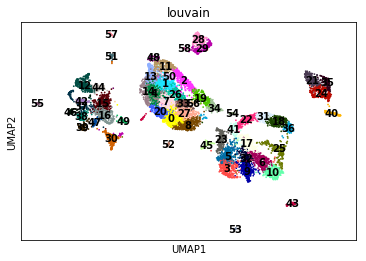

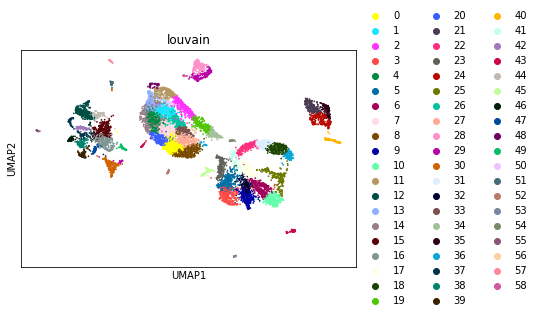

In [10]:
n_pcs = 75

all_cells_adata = sc.pp.log1p(raw_adata, copy=True)
sc.pp.highly_variable_genes(all_cells_adata,min_mean=0.1,max_mean=10,min_disp=0.5) 
sc.pp.scale(all_cells_adata) 
sc.tl.pca(all_cells_adata,svd_solver='arpack', use_highly_variable = True, 
          n_comps=n_pcs, random_state=1, zero_center=False) 
sc.pp.neighbors(all_cells_adata, n_pcs=n_pcs, n_neighbors = 15, random_state=1) 
sc.tl.umap(all_cells_adata, min_dist = 0.5, random_state=1, init_pos='random')
sc.tl.louvain(all_cells_adata, resolution = 5, random_state=1)
sc.pl.umap(all_cells_adata, color=['louvain'], legend_loc='on data')
sc.pl.umap(all_cells_adata, color=['louvain'])


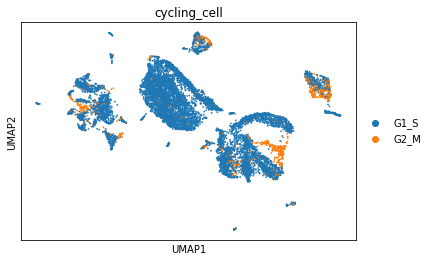

In [11]:
sc.pl.umap(all_cells_adata, color=['cycling_cell'])

## decontamination_1

...


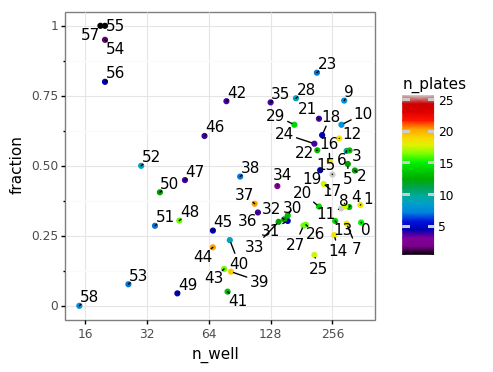

In [12]:
print('...')

# parse clusters 
input_adata = all_cells_adata
contam_stats = input_adata.obs.loc[:,['cell','louvain']]
contam_stats['well'] = [x.split('_')[0] for x in contam_stats.cell]
contam_stats['row'] = [x[0] for x in contam_stats.well]
contam_stats['col'] = [int(x[1:]) for x in contam_stats.well]
contam_stats['plate'] = [x.split('_')[1] for x in contam_stats.cell]
contam_stats = contam_stats.drop(['cell','well'], axis=1)
contam_stats = contam_stats.sort_values(['louvain','plate','row','col'])

# compute consective proportion
consec_df = pd.DataFrame()
for clust in set(contam_stats.louvain):
    input_clust = contam_stats[contam_stats.louvain==clust]
    wells_total = len(input_clust)
    series_total = 0
    n_plates = len(set(input_clust.plate))
    for plate in set(input_clust.plate):
        input_slice = input_clust[input_clust.plate==plate]

        for row in set(input_slice.row):
            row_slice = input_slice[input_slice.row == row]
            col_wells = row_slice.col.tolist()

            lol = [list(group) for group in mit.consecutive_groups(col_wells)]
            series_len = len([element for sublist in lol for element in sublist if len(sublist) > 1])

            series_total += series_len
    
    prop = series_total/wells_total
    consec_slice = pd.DataFrame({'fraction':[prop],
                                 'louvain':[clust],
                                 'n_well':[wells_total],
                                 'n_plates':[n_plates]
                                })
    consec_df = consec_df.append(consec_slice)
    
louvain_order = consec_df.sort_values('fraction', ascending=False).louvain.tolist()
consec_df['louvain'] = (consec_df['louvain']
                        .astype(str)
                        .astype(CategoricalDtype(louvain_order, ordered = True))
                       )

from adjustText import adjust_text

plotnine.options.figure_size=(4,4)
plot = (ggplot(consec_df)
        + theme_bw()
        + geom_point(aes('n_well','fraction',color='n_plates'))
        + geom_text(aes('n_well','fraction',label='louvain'))
        + scale_color_cmap('nipy_spectral')
        + scale_x_continuous(trans='log2')
       )

f = plot.draw()
for a in f.axes:
    texts = [t for t in  a.texts]
    adjust_text(texts,ax=a, arrowprops=dict(arrowstyle='-', color='#000000'),
#                 force_text=(0.1, 0.6),
#                 force_points=(0.5, 1),
#                 expand_text=(1.3, 1.3),
#                 expand_points=(1.3,4)
               )

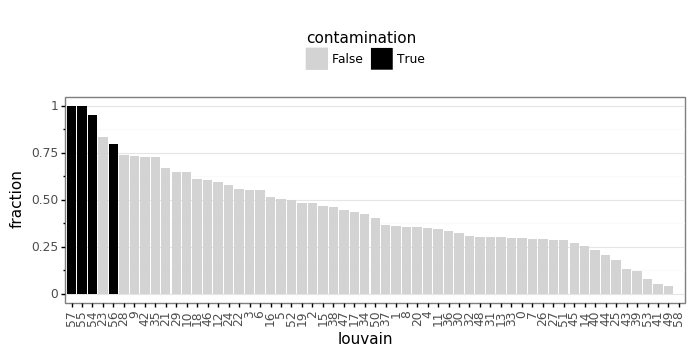

<ggplot: (-9223363262050569991)>


,cell_count
louvain,
cluster_54,20
cluster_55,20
cluster_56,20
cluster_57,19


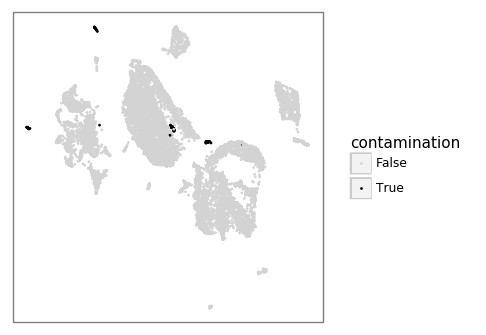

<ggplot: (8774793886500)>


In [13]:
blacklist = ['54','55','56','57']
consec_df['contamination'] = [x in blacklist for x in consec_df['louvain']]
color_code_dict = {True:'#000000',
                  False:'#D3D3D3'}

plotnine.options.figure_size=(8,8)
plot = (ggplot(consec_df)
        + theme_bw()
        + theme(aspect_ratio=1/3,
                legend_position='top',
                axis_text_x=element_text(angle=90),
                panel_grid_major_x=element_blank()
               )
        + geom_bar(aes('louvain','fraction',fill='contamination'), 
                   stat = 'identity')
        + scale_fill_manual(values=color_code_dict)
       )

print(plot)

# determine number of cells in each contam cluster
blacklist_stats = contam_stats[[x in blacklist for x in contam_stats.louvain]]
blacklist_stats = (blacklist_stats
                   .loc[:,['louvain','plate']]
                   .groupby('louvain')
                   .count()
                   .rename(columns={'plate':'cell_count'})
                  )
blacklist_stats = blacklist_stats[blacklist_stats.cell_count>0]
blacklist_stats = blacklist_stats.reset_index()
blacklist_stats['louvain'] = [f'cluster_{x}' for x in blacklist_stats['louvain']]
blacklist_stats = blacklist_stats.set_index('louvain')
display(blacklist_stats)

# compile contaminations
contam_list_1 = []
for x in blacklist:
    contam_list_1 = contam_list_1 + all_cells_adata.obs[all_cells_adata.obs.louvain == x].index.tolist()

# classify in all_cells_adata
input_adata = all_cells_adata
input_adata.obs['contam_1'] = [x in contam_list_1 for x in input_adata.obs.index]

# classify in raw_adata
raw_adata.obs['contam_1'] = [x in contam_list_1 for x in raw_adata.obs.index]

class_ref = 'contam_1'
input_adata = all_cells_adata
umap_df = pd.DataFrame(input_adata.obsm['X_umap'], columns = ['xvar','yvar'])
umap_df['contamination'] = input_adata.obs[class_ref].values
color_code_dict = {True:'#000000',
                  False:'#D3D3D3'}

plotnine.options.figure_size = (4,4)
plot = (ggplot(umap_df)
        + theme_bw()
        + theme(aspect_ratio = 1,
                panel_grid_major = element_blank(), 
                panel_grid_minor = element_blank(),
                axis_text = element_blank(),
                axis_title = element_blank(),
                axis_ticks = element_blank(),
               )
        + geom_point(aes('xvar','yvar',color='contamination'), size = 0.1)
        + scale_color_manual(values=color_code_dict)
       )
print(plot)


/home/ubuntu/py_36_env/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../py_36_env/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
... storing 'age_bin' as categorical
... storing 'plate' as categorical
... storing 'general_location' as categorical
... storing 'anatomical_location' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'color' as categorical
... storing 'patient' as categorical
... storing 'cycling_cell' as categorical


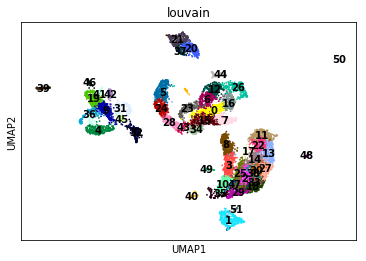

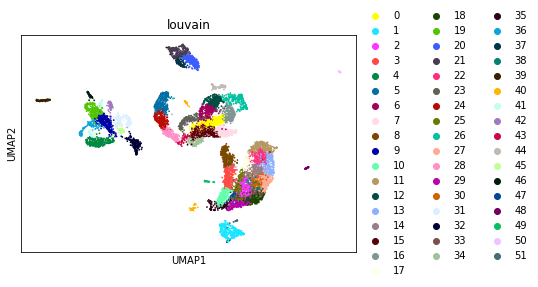

In [14]:
# reculster without contam

decontam_adata = raw_adata[raw_adata.obs['contam_1'] == False]
decontam_adata = sc.pp.log1p(decontam_adata, copy=True) # new
sc.pp.highly_variable_genes(decontam_adata,min_mean=0.1,max_mean=10,min_disp=0.5) # new
sc.pp.scale(decontam_adata) # new
sc.tl.pca(decontam_adata,svd_solver='arpack', use_highly_variable = True, 
          n_comps=n_pcs, random_state=1, zero_center=False) # new
sc.pp.neighbors(decontam_adata, n_pcs=n_pcs, n_neighbors=15, random_state=1) # new
sc.tl.umap(decontam_adata, min_dist = 0.5, random_state=1, init_pos='random')
sc.tl.louvain(decontam_adata, resolution = 5, random_state=1) # 4
sc.pl.umap(decontam_adata, color=['louvain'], legend_loc='on data')
sc.pl.umap(decontam_adata, color=['louvain'])


{'A1016LM', 'A1011L', 'A1025L', 'A1017LM'}


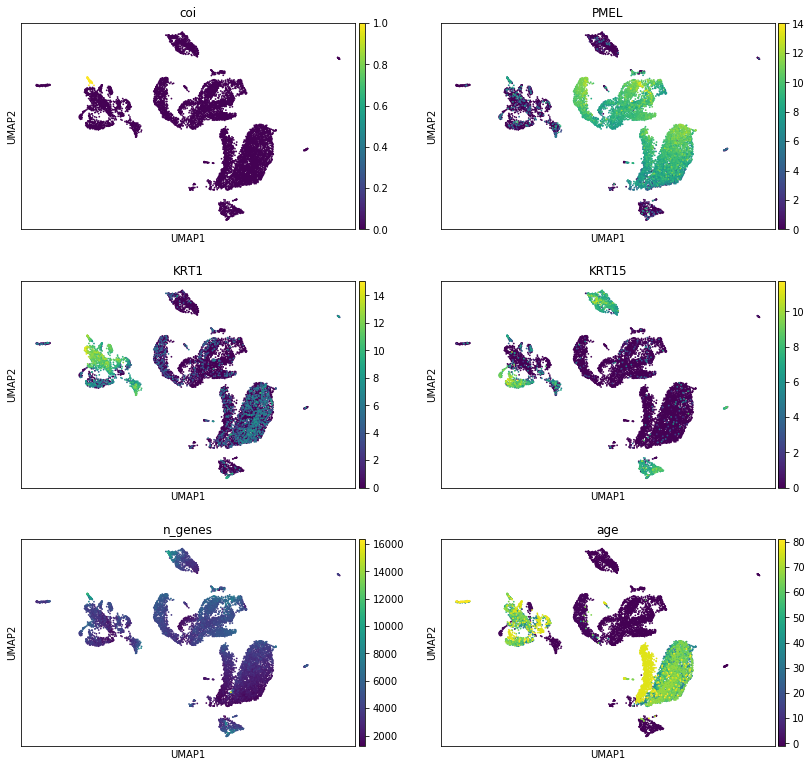

In [15]:
# doublet cluster identification

cluster = '46'
input_adata = decontam_adata
gene_n=10
input_adata.obs['coi'] = [x == cluster for x in input_adata.obs.louvain]
print(set(input_adata.obs[input_adata.obs['coi'] == True].patient))
sc.pl.umap(input_adata, color = ['coi','PMEL','KRT1','KRT15','n_genes','age'], ncols = 2
          )

## low-quality and doublet filter
low-quality (low n_genes)

doublet (co-expression of PMEL and KRT1/KRT15)

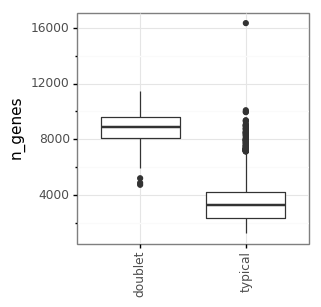

<ggplot: (8774802322373)>


,cell_count,mean_gene_count,median_gene_count,mean_read_count,median_read_count
coi,,,,,
doublet,45,8632,8899,3020096,3244876
typical,9699,3359,3286,1042191,620671


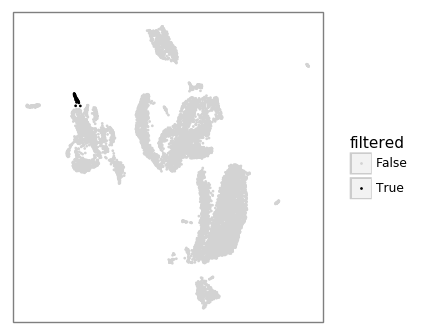

<ggplot: (-9223363262052127786)>


In [16]:
# n_genes of filtered cells
doublet_cluster = ['46']

input_adata = decontam_adata
ngene_df = input_adata.obs.loc[:,['louvain','n_genes','n_counts']]
ngene_df['coi'] = ['doublet' if x in doublet_cluster \
                   else 'typical' for x in ngene_df.louvain]

plotnine.options.figure_size = (3,3)
plot = (ggplot(ngene_df)
        + theme_bw()
        + theme(axis_title_x = element_blank(),
                axis_text_x = element_text(angle=90)
               )
        + geom_boxplot(aes('coi','n_genes'))
       )
print(plot)

filter_stats=pd.concat([ngene_df.loc[:,['coi','n_genes']].groupby('coi').count().rename(columns={'n_genes':'cell_count'}),
           ngene_df.loc[:,['coi','n_genes']].groupby('coi').mean().rename(columns={'n_genes':'mean_gene_count'}),
           ngene_df.loc[:,['coi','n_genes']].groupby('coi').median().rename(columns={'n_genes':'median_gene_count'}),
           ngene_df.loc[:,['coi','n_counts']].groupby('coi').mean().rename(columns={'n_counts':'mean_read_count'}),
           ngene_df.loc[:,['coi','n_counts']].groupby('coi').median().rename(columns={'n_counts':'median_read_count'}),
          ], axis=1).astype(int)
display(filter_stats)

# compile contaminations
contam_hi_ngenes = (decontam_adata.obs[[x in doublet_cluster for x in decontam_adata.obs.louvain]]
                    .index
                    .tolist()
                   )

full_contam = contam_list_1 + contam_hi_ngenes
full_contam = list(set(full_contam))

# classify in full_adata
input_adata = decontam_adata
input_adata.obs['contam_2'] = [x in full_contam for x in input_adata.obs.index]

# classify in raw_adata
raw_adata.obs['contam_2'] = [x in full_contam for x in raw_adata.obs.index]

class_ref = 'contam_2'
input_adata = decontam_adata
umap_df = pd.DataFrame(input_adata.obsm['X_umap'], columns = ['xvar','yvar'])
umap_df['filtered'] = input_adata.obs[class_ref].values
color_code_dict = {True:'#000000',
                  False:'#D3D3D3'}

plotnine.options.figure_size = (4,4)
plot = (ggplot(umap_df)
        + theme_bw()
        + theme(aspect_ratio = 1,
                panel_grid_major = element_blank(), 
                panel_grid_minor = element_blank(),
                axis_text = element_blank(),
                axis_title = element_blank(),
                axis_ticks = element_blank(),
               )
        + geom_point(aes('xvar','yvar',color='filtered'), size = 0.1)
        + scale_color_manual(values=color_code_dict)
       )
print(plot)

/home/ubuntu/py_36_env/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../py_36_env/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
... storing 'age_bin' as categorical
... storing 'plate' as categorical
... storing 'general_location' as categorical
... storing 'anatomical_location' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'color' as categorical
... storing 'patient' as categorical
... storing 'cycling_cell' as categorical


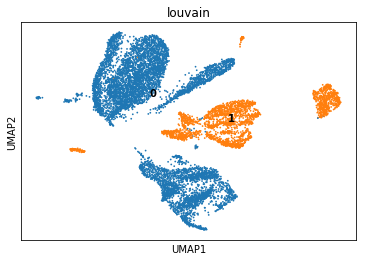

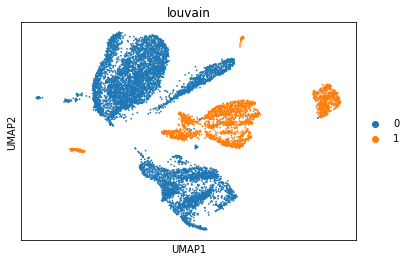

In [17]:
# recluster, remove doublets

full_adata = raw_adata[raw_adata.obs['contam_2'] == False]
full_adata = sc.pp.log1p(full_adata, copy=True) # new
sc.pp.highly_variable_genes(full_adata,min_mean=0.1,max_mean=10,min_disp=0.5) # new
sc.pp.scale(full_adata) # new
sc.tl.pca(full_adata,svd_solver='arpack', use_highly_variable = True, 
          n_comps=n_pcs, random_state=1, zero_center=False) # new
sc.pp.neighbors(full_adata, n_pcs=n_pcs, n_neighbors=65, random_state=1) # new
sc.tl.umap(full_adata, min_dist = 0.5, random_state=1, init_pos='random')
sc.tl.louvain(full_adata, resolution = 0.02, random_state=1)
sc.pl.umap(full_adata, color=['louvain'], legend_loc='on data')
sc.pl.umap(full_adata, color=['louvain'])


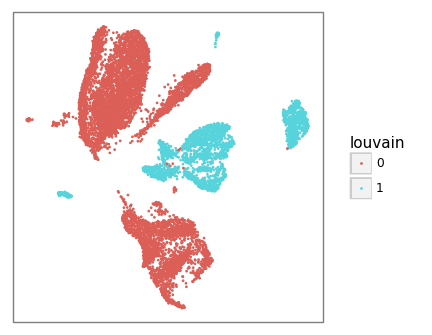

<ggplot: (8774802767466)>


In [18]:
class_ref = 'louvain'
input_adata = full_adata
umap_df = pd.DataFrame(input_adata.obsm['X_umap'], columns = ['xvar','yvar'])
umap_df[class_ref] = input_adata.obs[class_ref].values
color_code_dict = {True:'#000000',
                  False:'#D3D3D3'}

plotnine.options.figure_size = (4,4)
plot = (ggplot(umap_df)
        + theme_bw()
        + theme(aspect_ratio = 1,
                panel_grid_major = element_blank(), 
                panel_grid_minor = element_blank(),
                axis_text = element_blank(),
                axis_title = element_blank(),
                axis_ticks = element_blank(),
               )
        + geom_point(aes('xvar','yvar',color=class_ref), size = 0.1)
       )
print(plot)


# iterative re-clustering

## cluster_0

... storing 'age_bin' as categorical
... storing 'plate' as categorical
... storing 'general_location' as categorical
... storing 'anatomical_location' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'color' as categorical
... storing 'patient' as categorical
... storing 'cycling_cell' as categorical


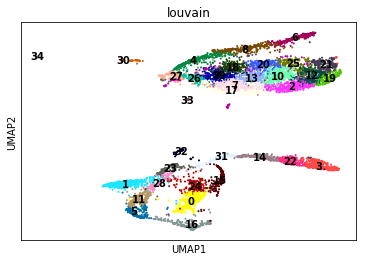

In [19]:
coi = full_adata[full_adata.obs.louvain == '0'].obs.index.tolist()
raw_adata.obs['recluster'] = [x in coi for x in raw_adata.obs.index]
recluster_0 = raw_adata[raw_adata.obs['recluster'] == True]
recluster_0 = sc.pp.log1p(recluster_0, copy=True) # new
sc.pp.highly_variable_genes(recluster_0,min_mean=0.1,max_mean=10,min_disp=0.5) # new
sc.pp.scale(recluster_0) # new
sc.tl.pca(recluster_0,svd_solver='arpack', use_highly_variable = True, 
          n_comps=n_pcs, random_state=1, zero_center=False) # new
sc.pp.neighbors(recluster_0, n_pcs=n_pcs, n_neighbors=29, random_state=1) # new
sc.tl.umap(recluster_0, min_dist = 0.15, random_state=1, init_pos='random')
sc.tl.louvain(recluster_0, resolution = 4, random_state=1)
sc.pl.umap(recluster_0, color=['louvain'], legend_loc='on data')

In [20]:
## well series test
for cluster in [32,33,34,30]:
    cluster = str(cluster)
    print(cluster)
    gene_n = 10
    input_adata = recluster_0
    input_adata.obs['coi'] = [x == cluster for x in input_adata.obs.louvain]
    print(set(input_adata.obs[input_adata.obs['coi'] == True].patient))
    sc.tl.rank_genes_groups(input_adata, groupby='louvain', groups=[cluster], method='wilcoxon',reference='rest')
    # top DEGs
    print([x[0] for x in input_adata.uns['rank_genes_groups']['names']][:gene_n])

32
{'12WKM01', '10WK03', '9.5WK02', '18WKM06', 'A1020LM'}
['COL1A1', 'COL3A1', 'COL1A2', 'PRRX1', 'TCF4', 'CXCL14', 'TWIST1', 'MEG3', 'COL5A2', 'COL5A1']
33
{'A1038LM', 'A1033M', 'A1011L', 'A1020LM', 'A1046M'}
['CD52', 'IL32', 'CORO1A', 'S100A4', 'IL2RG', 'PTPRCAP', 'CD3D', 'LTB', 'RAC2', 'ARHGDIB']
34
{'12WKM01', 'A1038LM', '10WK03', 'FS043_LM', '9.5WK02', '18WKM06'}
['TPSB2', 'TPSAB1', 'MS4A2', 'GATA2', 'CPA3', 'SLC18A2', 'HDC', 'C1orf186', 'LAPTM5', 'FCER1G']
30
{'12WKM01', 'A1038LM', '10WK03', '12WK05', 'A1046M', '9.5WK02', 'A1025L', 'A1033M', '18WKM06', 'A1011L'}
['TYROBP', 'AIF1', 'CSF1R', 'LAPTM5', 'LCP1', 'ARHGDIB', 'TMSB4X', 'C1QC', 'FCGR2A', 'FCER1G']


... storing 'named_cluster' as categorical


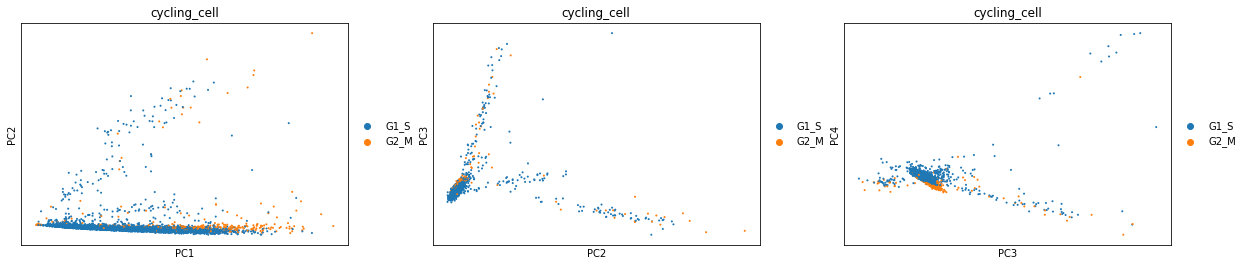

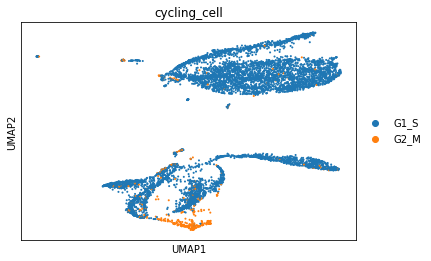

In [21]:
# append named_cluster
input_adata = recluster_0
anno_dict_0 = {
                '33':'dendritic',
                '32':'follicular_mel',
                '30':'T-cell',
                '34':'mast',
              }
for x in [x for x in set(input_adata.obs.louvain) \
          if x not in anno_dict_0.keys()]:
    anno_dict_0[x] = f'mel_{x}'
    
input_adata.obs['named_cluster'] = [anno_dict_0.get(x) for x in input_adata.obs.louvain]

# update cycling cell
input_adata.obs.named_cluster = [f'cyc_{x}' if y == 'G2_M' \
                                 else x \
                                 for x,y in zip(input_adata.obs.named_cluster,
                                                    input_adata.obs.cycling_cell)]
# plot cycling cell output
sc.pl.pca(input_adata, components=['1,2', '2,3','3,4'], color=['cycling_cell'])
sc.pl.umap(input_adata, color=['cycling_cell'], cmap='nipy_spectral')


###  recluster hair follicle cluster

... storing 'age_bin' as categorical
... storing 'plate' as categorical
... storing 'general_location' as categorical
... storing 'anatomical_location' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'color' as categorical
... storing 'patient' as categorical
... storing 'cycling_cell' as categorical


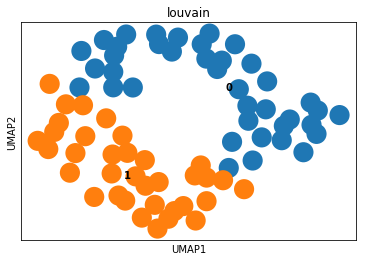

In [22]:
n_pcs = 15
coi = recluster_0[recluster_0.obs.louvain == [x for x,y in anno_dict_0.items() if y == 'follicular_mel'][0]].obs.index.tolist()
raw_adata.obs['recluster'] = [x in coi for x in raw_adata.obs.index]
recluster_0_foll = raw_adata[raw_adata.obs['recluster'] == True]
recluster_0_foll = sc.pp.log1p(recluster_0_foll, copy=True) # new
sc.pp.highly_variable_genes(recluster_0_foll,min_mean=0.1,
                            max_mean=10,min_disp=0.5) # new
sc.pp.scale(recluster_0_foll) # new
sc.tl.pca(recluster_0_foll,svd_solver='arpack', use_highly_variable = True, 
          n_comps=n_pcs, random_state=1, zero_center=False) # new
sc.pp.neighbors(recluster_0_foll, n_pcs=n_pcs, n_neighbors=10, random_state=1) # new
sc.tl.umap(recluster_0_foll, min_dist = 0.5, random_state=1, init_pos='random')
sc.tl.louvain(recluster_0_foll, resolution = 0.3, random_state=1)
sc.pl.umap(recluster_0_foll, color=['louvain'], legend_loc='on data')


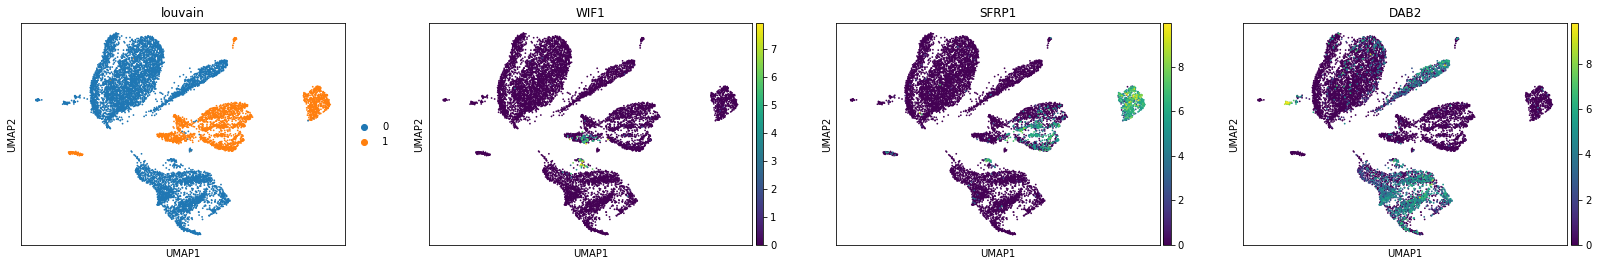

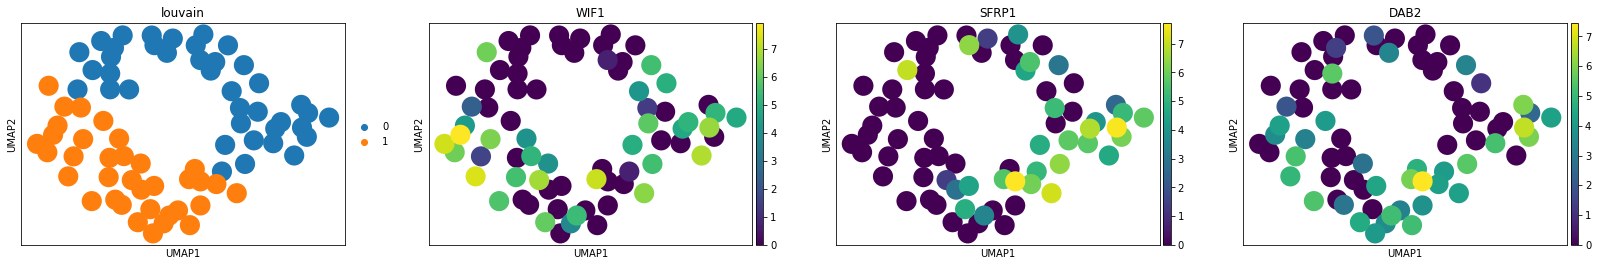

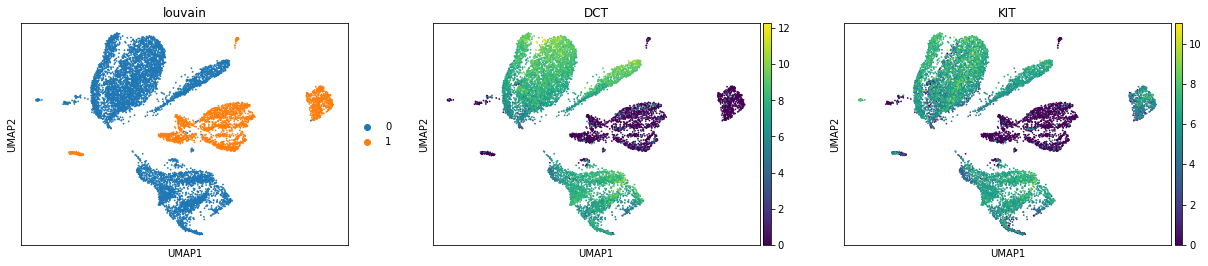

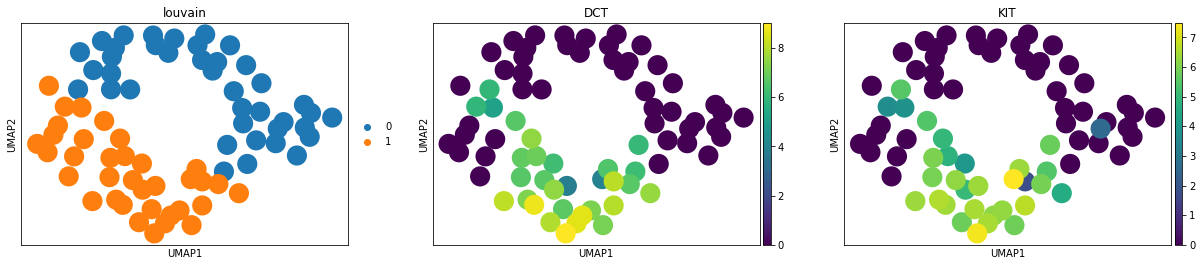

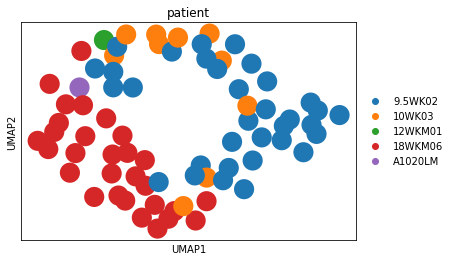

In [23]:
#ref: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3582991/

gois = ['WIF1','SFRP1','DAB2']
sc.pl.umap(full_adata, color=['louvain']+gois)
sc.pl.umap(recluster_0_foll, color=['louvain']+gois)

gois = ['DCT','KIT']
sc.pl.umap(full_adata, color=['louvain']+gois)
sc.pl.umap(recluster_0_foll, color=['louvain']+gois)

sc.pl.umap(recluster_0_foll, color = ['patient'], ncols = 1)

... storing 'named_cluster' as categorical


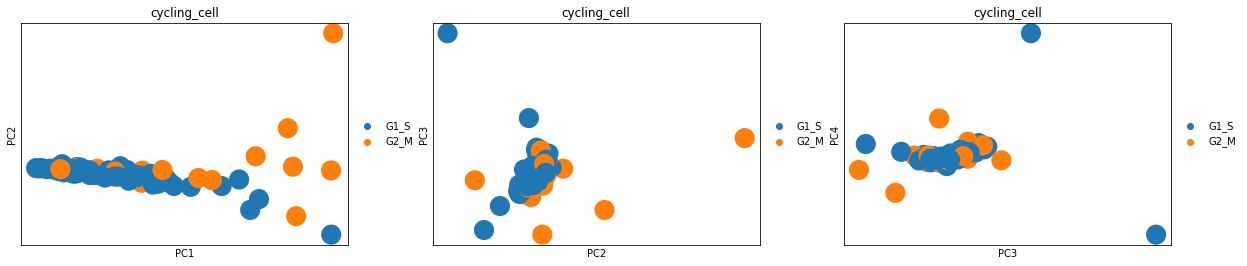

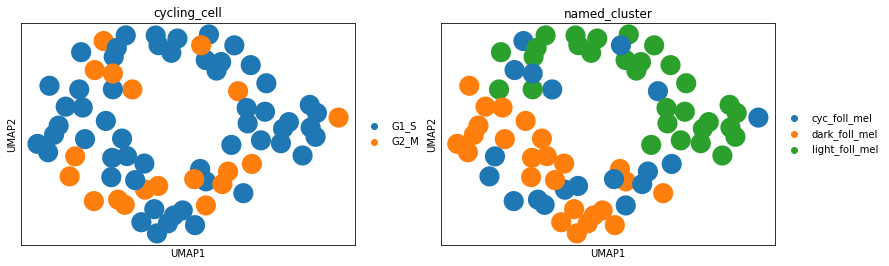

In [24]:
# append named_cluster
input_adata = recluster_0_foll
anno_dict_foll = {'1':'dark_foll_mel',
               '0':'light_foll_mel',
              }

# add updated labels
input_adata.obs['named_cluster'] = [anno_dict_foll.get(x) for x in input_adata.obs.louvain]

# update cycling cell
input_adata.obs.named_cluster = [f'cyc_foll_mel' if y == 'G2_M' \
                                 else x \
                                 for x,y in zip(input_adata.obs.named_cluster,
                                                    input_adata.obs.cycling_cell)]

# plot cycling cell output
sc.pl.pca(input_adata, components=['1,2', '2,3','3,4'], color=['cycling_cell'])
sc.pl.umap(input_adata, color=['cycling_cell','named_cluster'], cmap='nipy_spectral')

# update recluster_0
ref_adata = recluster_0[recluster_0.obs.louvain != [x for x,y in anno_dict_0.items() if y == 'follicular_mel'][0]]
rename_df = (pd.DataFrame(ref_adata.obs.loc[:,'named_cluster'])
             .append(pd.DataFrame(input_adata.obs.loc[:,'named_cluster'])))
named_cluster_df = pd.merge(pd.DataFrame(recluster_0.obs.index).rename(columns = {0:'index'}),
                          rename_df.loc[:,['named_cluster']].reset_index(),
                          'left',
                          'index')
recluster_0.obs['named_cluster'] = named_cluster_df.named_cluster.tolist()  


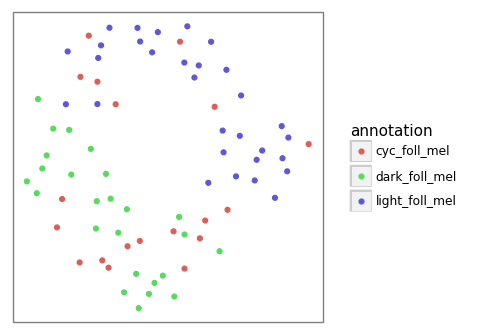

<ggplot: (8774803074529)>


In [25]:
class_ref = 'named_cluster'
input_adata = recluster_0_foll
umap_df = pd.DataFrame(input_adata.obsm['X_umap'], columns = ['xvar','yvar'])
umap_df['annotation'] = input_adata.obs[class_ref].values

plotnine.options.figure_size = (4,4)
plot = (ggplot(umap_df)
        + theme_bw()
        + theme(aspect_ratio = 1,
                panel_grid_major = element_blank(), 
                panel_grid_minor = element_blank(),
                axis_text = element_blank(),
                axis_title = element_blank(),
                axis_ticks = element_blank(),
               )
        + geom_point(aes('xvar','yvar',color='annotation'))
       )
print(plot)

## cluster_1

... storing 'age_bin' as categorical
... storing 'plate' as categorical
... storing 'general_location' as categorical
... storing 'anatomical_location' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'color' as categorical
... storing 'patient' as categorical
... storing 'cycling_cell' as categorical


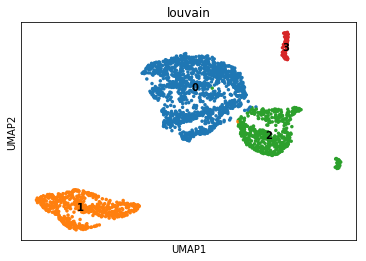

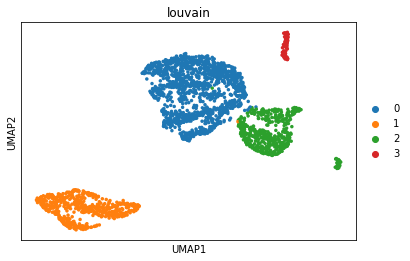

In [26]:
coi = full_adata[full_adata.obs.louvain == '1'].obs.index.tolist()
raw_adata.obs['recluster'] = [x in coi for x in raw_adata.obs.index]
recluster_1 = raw_adata[raw_adata.obs['recluster'] == True]
recluster_1 = sc.pp.log1p(recluster_1, copy=True) # new
sc.pp.highly_variable_genes(recluster_1,min_mean=0.1,max_mean=10,min_disp=0.5) # new
sc.pp.scale(recluster_1) # new
sc.tl.pca(recluster_1,svd_solver='arpack', use_highly_variable = True, 
          n_comps=n_pcs, random_state=1, zero_center=False) # new
sc.pp.neighbors(recluster_1, n_pcs=n_pcs, n_neighbors=35, random_state=1) # new
sc.tl.umap(recluster_1, min_dist = 0.5, random_state=1, init_pos='random')
sc.tl.louvain(recluster_1, resolution = 0.1, random_state=1)
sc.pl.umap(recluster_1, color=['louvain'], legend_loc='on data')
sc.pl.umap(recluster_1, color=['louvain'])


... storing 'named_cluster' as categorical


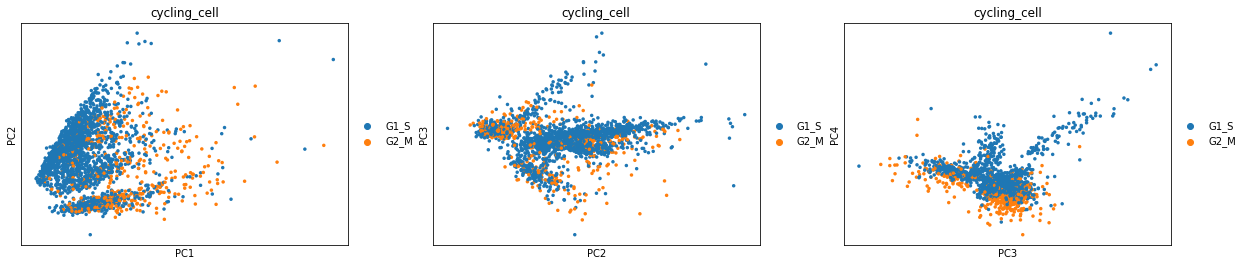

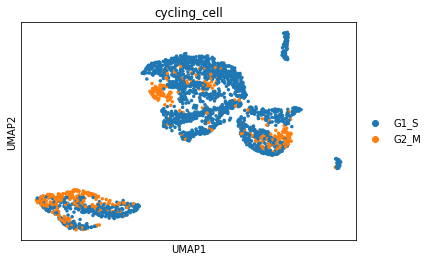

In [27]:
# append named_cluster
input_adata = recluster_1
anno_dict_krt = {'0':'krt_0',
               '1':'eccrine_0',
               '2':'krt_1',
               '3':'eccrine_1',
              }
# full_adata.obs['named_cluster'] = [f'mel_{x}' if x not in anno_dict_1.keys() \
#                                              else '{}'.format(anno_dict_0[x]) \
#                                              for x in full_adata.obs.louvain]

input_adata.obs['named_cluster'] = [anno_dict_krt.get(x) for x in input_adata.obs.louvain]

# update cycling cell
input_adata.obs.named_cluster = [f'cyc_{x}' if y == 'G2_M' \
                                 else x \
                                 for x,y in zip(input_adata.obs.named_cluster,
                                                    input_adata.obs.cycling_cell)]
# plot cycling cell output
sc.pl.pca(input_adata, components=['1,2', '2,3','3,4'], color=['cycling_cell'])
sc.pl.umap(input_adata, color=['cycling_cell'], cmap='nipy_spectral')


# annotations

## merge recluster annotations

... storing 'named_cluster' as categorical


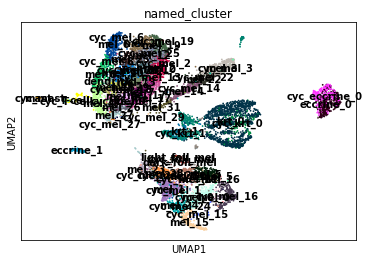

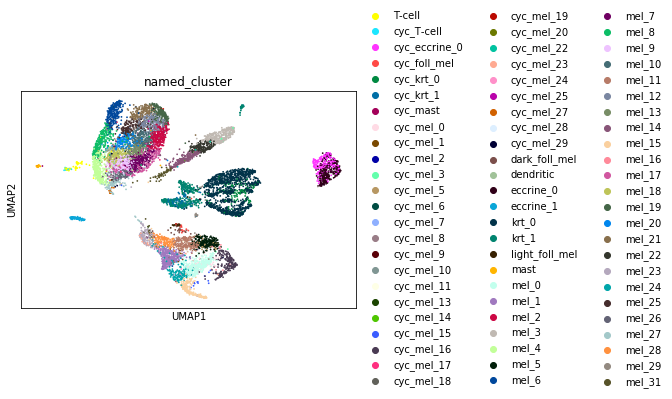

In [28]:
recluster_merge = recluster_1.obs.append(recluster_0.obs)
named_cluster_df = pd.merge(pd.DataFrame(full_adata.obs.index).rename(columns = {0:'index'}),
                          recluster_merge.loc[:,['named_cluster']].reset_index(),
                          'left',
                          'index')

full_adata.obs['named_cluster'] = named_cluster_df.named_cluster.tolist()
sc.pl.umap(full_adata, color = 'named_cluster', legend_loc = 'on data')
sc.pl.umap(full_adata, color = 'named_cluster')


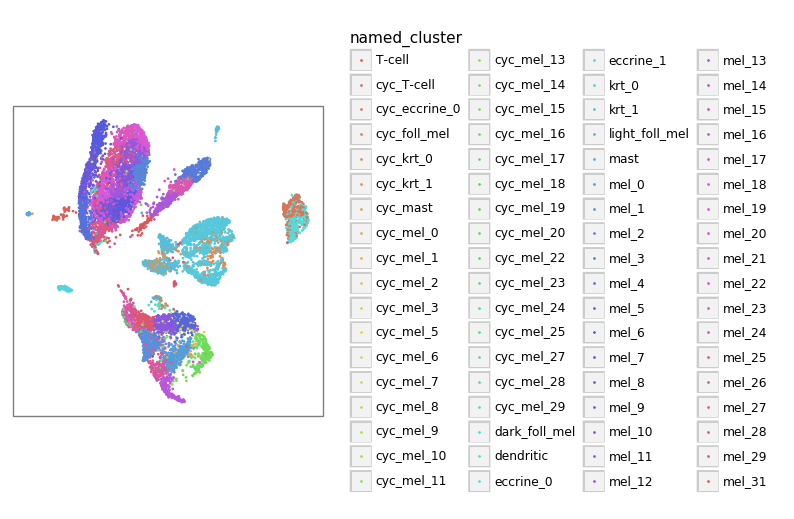

<ggplot: (8774803599771)>


In [29]:
class_ref = 'named_cluster'
input_adata = full_adata
umap_df = pd.DataFrame(input_adata.obsm['X_umap'], columns = ['xvar','yvar'])
umap_df[class_ref] = input_adata.obs[class_ref].values

plotnine.options.figure_size = (4,4)
plot = (ggplot(umap_df)
        + theme_bw()
        + theme(aspect_ratio = 1,
                panel_grid_major = element_blank(), 
                panel_grid_minor = element_blank(),
                axis_text = element_blank(),
                axis_title = element_blank(),
                axis_ticks = element_blank(),
               )
        + geom_point(aes('xvar','yvar',color=class_ref), size = 0.1)
       )
print(plot)

## label updates

In [30]:
# update labels
dev_stage_order = ['fet','neo','adt']
subtypes_order = ['acral','foreskin','cutaneous']
acral_subtype_order = ['acral','not_acral']
foreskin_subtype_order = ['foreskin','not_foreskin']
dev_subtype_order = ['fet_acral','fet_cutaneous','neo_foreskin','adt_acral','adt_cutaneous']

for input_adata in [full_adata,recluster_0,recluster_1]:
    input_adata.obs['true_year'] = [float(x.split('WK')[0])/52 if len(x.split('WK')[0]) <= 3 else np.nan for x in input_adata.obs.patient]
    input_adata.obs['true_year'] = [y+(9/12) if np.isnan(x) else x for x,y in zip(input_adata.obs['true_year'], input_adata.obs['age']) ]

    input_adata.obs['dev_stage'] = ['adt' if x > 0 else 'neo' if x == 0 else 'fet' for x in input_adata.obs.age]
    input_adata.obs['subtypes'] = [x if x in ['acral','foreskin'] else 'cutaneous' for x in input_adata.obs.general_location]
    input_adata.obs['acral_subtype'] = [x if x == 'acral' else 'not_acral' for x in input_adata.obs['subtypes']]
    input_adata.obs['dev_subtype'] = [f'{x}_{y}' for x,y in zip(input_adata.obs.dev_stage, input_adata.obs.subtypes)]

    for i in ['dev_stage', 'subtypes', 'acral_subtype' ,'dev_subtype']:
        input_adata.obs[i] =  (input_adata
                                 .obs[i]
                                 .astype(str)
                               .astype(CategoricalDtype(eval(f'{i}_order'), ordered = True))
                              )  
        
    input_adata.obs['class_1'] = ['_'.join(x.split('_')[:-1]) if x.split('_')[-1].isdigit() \
                                      else '_'.join(x.split('_')) \
                                      for x in input_adata.obs['named_cluster']]
     

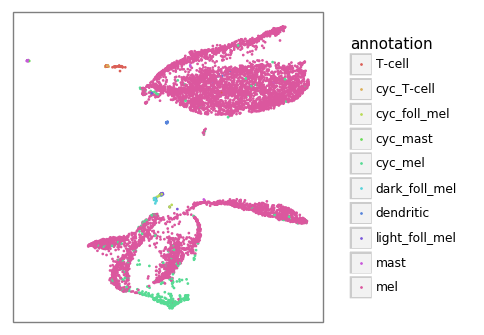

<ggplot: (8774803185216)>


In [31]:
class_ref = 'class_1'
input_adata = recluster_0
umap_df = pd.DataFrame(input_adata.obsm['X_umap'], columns = ['xvar','yvar'])
umap_df['annotation'] = input_adata.obs[class_ref].values

plotnine.options.figure_size = (4,4)
plot = (ggplot(umap_df)
        + theme_bw()
        + theme(aspect_ratio = 1,
                panel_grid_major = element_blank(), 
                panel_grid_minor = element_blank(),
                axis_text = element_blank(),
                axis_title = element_blank(),
                axis_ticks = element_blank(),
               )
        + geom_point(aes('xvar','yvar',color='annotation'), size = 0.1)
       )
print(plot)

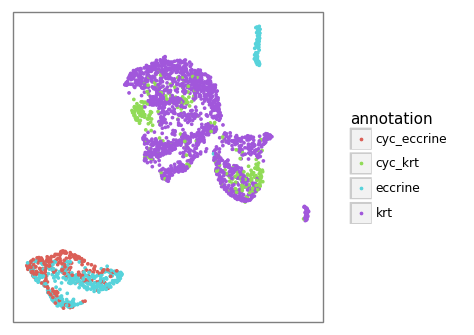

<ggplot: (-9223363262051637809)>


In [32]:
class_ref = 'class_1'
input_adata = recluster_1
umap_df = pd.DataFrame(input_adata.obsm['X_umap'], columns = ['xvar','yvar'])
umap_df['annotation'] = input_adata.obs[class_ref].values

plotnine.options.figure_size = (4,4)
plot = (ggplot(umap_df)
        + theme_bw()
        + theme(aspect_ratio = 1,
                panel_grid_major = element_blank(), 
                panel_grid_minor = element_blank(),
                axis_text = element_blank(),
                axis_title = element_blank(),
                axis_ticks = element_blank(),
               )
        + geom_point(aes('xvar','yvar',color='annotation'), size = 0.5)
       )
print(plot)

## DE genes as function of annotation

In [33]:
def fast_DE(input_adata, clusterOI, groupby, reference='rest', n_genes=10):
    sc.tl.rank_genes_groups(input_adata, 
                            groupby=groupby, 
                            groups=[clusterOI], 
                            method='wilcoxon',
                            reference=reference,
                            n_genes = n_genes)
    gene = [x[0] for x in input_adata.uns['rank_genes_groups']['names']]
    return gene

In [34]:
input_adata = full_adata
DE_df = pd.DataFrame()
type_order = ['mel',
                'cyc_mel',
                'dark_foll_mel',
                'light_foll_mel',
                'cyc_foll_mel',
                'krt',
                'cyc_krt',
                'eccrine',
                'cyc_eccrine',
                'dendritic',
                'cyc_dendritic',
                'mast',
                'T-cell',
             ]
for x in tqdm.tqdm(type_order):
    try:
        tmpdf = pd.DataFrame()
        sc.tl.rank_genes_groups(input_adata, 
                            groupby='class_1', 
                            groups=[x], 
                            method='wilcoxon',
                            reference='rest',
                            n_genes = 10)
        
        tmpdf['gene'] = [x[0] for x in input_adata.uns['rank_genes_groups']['names']]
        tmpdf['class_1'] = x
        DE_df = DE_df.append(tmpdf)
    except Exception as e:
        print (e)
    
# DE_df['class_1'] = (DE_df['class_1']
#                       .astype(str)
#                       .astype(CategoricalDtype(type_order, ordered=True))
#                      )
    
# gene_order = DE_df[~DE_df.gene.duplicated(keep='first')].gene.tolist()

 77%|███████▋  | 10/13 [02:15<00:40, 13.48s/it]

index 0 is out of bounds for axis 0 with size 0


100%|██████████| 13/13 [02:42<00:00, 12.51s/it]


## Marker gene citations

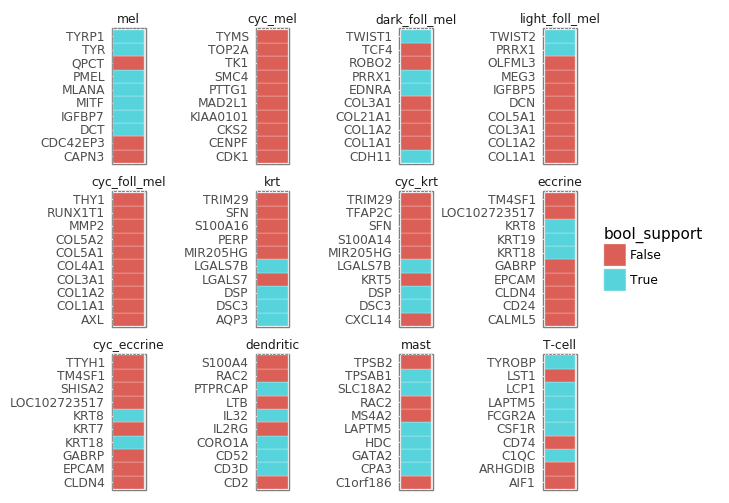

<ggplot: (-9223363262051481838)>


,class_1,cite
0,mel,10.1101/cshperspect.a017046
1,cyc_mel,10.1101/cshperspect.a017046
0,krt,10.1016/j.celrep.2018.09.006
1,cyc_krt,10.1016/j.celrep.2018.09.006
0,krt,10.1038/jid.2010.395
1,cyc_krt,10.1038/jid.2010.395
0,eccrine,10.1111/exd.12773
1,cyc_eccrine,10.1111/exd.12773
0,dendritic,10.1038/jid.2013.375
1,cyc_dendritic,10.1038/jid.2013.375


In [35]:
cite_dict = {'10.1101/cshperspect.a017046':['TYR','TYRP1','DCT','MITF','IGFBP7','PMEL','MLANA'], # mel
             '10.1016/j.celrep.2018.09.006':['DSP','DSC3','LGALS7B'], # krt
             '10.1038/jid.2010.395':['AQP3'], # krt
             '10.1111/exd.12773':['KRT18','KRT19','KRT8'], # eccrine
             '10.1038/jid.2013.375':['FCGR2A','FCER1G','C1QC','LAPTM5','CSF1R','AIF1'], # dendritic
             '10.1182/blood-2013-02-483792':['LAPTM5','FCER1G','SLC18A2','GATA2'], # mast
             '10.1084/jem.20170910':['TPSAB1','CPA3','HDC','GATA2'], # mast
             '10.1038/s41598-017-01468-y':['TYROBP','CSF1R','LAPTM5','FCGR2A','FCER1G','LCP1','CD4','C1QC',
                                           'FYB','CORO1A','CXCR4','CD3D','CD52','PTPRCAP','IL32'], # T cell
#              '10.1158/0008-5472.CAN-09-0783':['COL1A1','COL3A1','COL1A2',
#                                               'PRRX1','COL6A2','COL21A1','MEG3'] # nevus 
             '10.1371/journal.pgen.1008034':['EDNRA','PRRX1','CDH11','COL6A2','TWIST1','TWIST2'], # msc
#              '10.1371/journal.pone.0115717':['DCN','CLDN11','OLFML3'] # fibroblast
            }

cite_df = pd.DataFrame()
for key,value in cite_dict.items():
    df_slice = pd.DataFrame({'gene':value})
    df_slice['cite'] = key
    cite_df = cite_df.append(df_slice)    
DE_cite_df = pd.merge(DE_df, cite_df, 'left', 'gene')

cite2class = {'10.1101/cshperspect.a017046':['mel','cyc_mel'],
              '10.1016/j.celrep.2018.09.006':['krt','cyc_krt'],
              '10.1038/jid.2010.395':['krt','cyc_krt'],
              '10.1111/exd.12773':['eccrine','cyc_eccrine'],
              '10.1038/jid.2013.375':['dendritic','cyc_dendritic'],
              '10.1038/s41598-017-01468-y':['dendritic','cyc_dendritic','T-cell','cyc_T-cell'],
              '10.1182/blood-2013-02-483792':['mast','cyc_mast'],
              '10.1084/jem.20170910':['mast','cyc_mast'],
              '10.1371/journal.pgen.1008034':['light_foll_mel','dark_foll_mel','cyc_foll_mel'],
             }

DE_cite_df['support'] = [y in cite2class.get(x) if x is not np.nan \
                         else False for x,y in zip(DE_cite_df.cite, DE_cite_df.class_1)]
DE_cite_df['class_1'] = (DE_cite_df['class_1']
                      .astype(str)
                      .astype(CategoricalDtype(type_order, ordered=True))
                     )
plot_df = pd.DataFrame(DE_cite_df.groupby(['class_1','gene'])['support'].sum()).reset_index()
plot_df['bool_support'] = [x > 0 for x in plot_df['support']]
plot_df['xvar'] = 0
plot_df['class_1'] = (plot_df['class_1']
                      .astype(str)
                      .astype(CategoricalDtype(type_order, ordered=True))
                     )
plot_df = plot_df.dropna()

plotnine.options.figure_size = (6,6)
plot = (ggplot(plot_df)
        + theme_bw()
        + theme(panel_spacing_x = 1.1,
                axis_text_x = element_blank(),
                strip_background = element_blank(),
                axis_ticks = element_blank()
               )
        + geom_tile(aes('xvar','gene', fill = 'bool_support'), color = 'white')
        + facet_wrap('~class_1', scales = 'free')
        + labs(x = '', y = '')
#         + scale_fill_manual(values = ['red','green','blue','orange','purple','yellow','pink','brown','grey','white'])
       )
print(plot)

# table of cell annotations and citations
cite2class_df = pd.DataFrame()
for key,value in cite2class.items():
    df_slice = pd.DataFrame({'class_1':value})
    df_slice['cite'] = key
    cite2class_df = cite2class_df.append(df_slice)
cite2class_df['class_1'] = (cite2class_df['class_1']
                      .astype(str)
                      .astype(CategoricalDtype(type_order, ordered=True))
                     )
display(cite2class_df.dropna())
